In [1]:
import os
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

plt.ioff()
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

tfkl = tf.keras.layers
tfpl = tfp.layers
tf.keras.backend.set_floatx("float64")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
def load_mdn(DT, N_C, user):
    """
    Loads MDN model.
    """

    model = tf.keras.Sequential(
        [tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(N_C * 15, activation=None),
         tfpl.MixtureSameFamily(N_C, tfpl.MultivariateNormalTriL(4))])

    model.load_weights(
        f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/trained/weights.index").expect_partial()
    return model

In [3]:
def load_scalers(DT, N_C, user):
    """
    Loads scaler objects relating to MDN models.
    """

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Xscaler.pkl", "rb") as file:
        Xscaler = pickle.load(file)

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Yscaler.pkl", "rb") as file:
        Yscaler = pickle.load(file)
    return Xscaler, Yscaler

def given(X_1, X_0, X_scaler, Y_scaler, model):
    """
    Evaluates transition density for fixed X_0.
    """
    dx = np.abs(X_1 - X_0)
    return Y_scaler.invert_standardisation_prob(
        np.exp(
            model.log_prob(
                X_scaler.standardise(dx)))
        )

def make_position(A0: list, B0: list) -> np.array:
    if not isinstance(A0, np.ndarray):
        A0 = np.array(A0).reshape((2, 1))

    if not isinstance(B0, np.ndarray):
        B0 = np.array(B0).reshape((2, 1))

    return np.vstack([A0, B0]).reshape(4, 1) 

In [4]:
def plot_arrow(A0, A1):
    plt.arrow(A0[0].item(), A0[1].item(), (A1[0] - A0[0]).item(), (A1[1] - A0[0]).item(),
              color='black', head_width=0.015, length_includes_head=True)

def generate_circle_points(num_points: int, radius: float):
    # Generate angles equally spaced between 0 and 2*pi
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    
    # Calculate x and y coordinates using trigonometry
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return x, y

def plot_many_arrows(x, y, ax, n, arrow_length=0.08, arrow_width=0.25):
    x_p, y_p = generate_circle_points(n, arrow_length)
    for i in range(len(x_p)):
        dx = x - x_p[i]
        dy = y - y_p[i]
        ax.annotate('', xy=(dx, dy), xytext=(x, y), arrowprops=dict(facecolor='blue', arrowstyle='->', linewidth=arrow_width), zorder=1)

In [5]:
def plot_positions(A0, B0, C0, D0, A1, C1):
    # Create our axes.
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    def format_xy(p):
        return f"({p[0].item()}, {p[1].item()})"

    # Particle A.
    ax.scatter(A0[0], A0[1], label=f"$A_0 = {format_xy(A0)}$", color="r")
    ax.scatter(A1[0], A1[1], label=f"$A_1 = {format_xy(A1)}$", facecolors='none', edgecolors="r", linestyle='dotted')
    plot_arrow(A0, A1)

    # Particle B.
    # Add arrows to indicate that particle B goes everywhere.
    plot_many_arrows(B0[0], B0[1], ax, 8)
    ax.scatter(B0[0], B0[1], label=f"$B_0 = {format_xy(B0)}$", color="b", zorder=2)

    # Particle C.
    ax.scatter(C0[0], C0[1], label=f"$C_0 = {format_xy(C0)}$", color="purple")
    ax.scatter(C1[0], C1[1], label=f"$C_1 = {format_xy(C1)}$", facecolors='none', edgecolors="purple", linestyle='dotted')
    plot_arrow(C0, C1)

    # Particle D.
    # Add arrows to indicate that particle C goes everywhere.
    plot_many_arrows(D0[0], D0[1], ax, 8)
    ax.scatter(D0[0], D0[1], label=f"$D_0 = {format_xy(D0)}$", color="g", zorder=2)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_axisbelow(True)

    # Show the major grid and style it slightly.
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    # Show the minor grid as well. Style it in very light gray as a thin,
    # dotted line.
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()

    plt.show()
    return

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


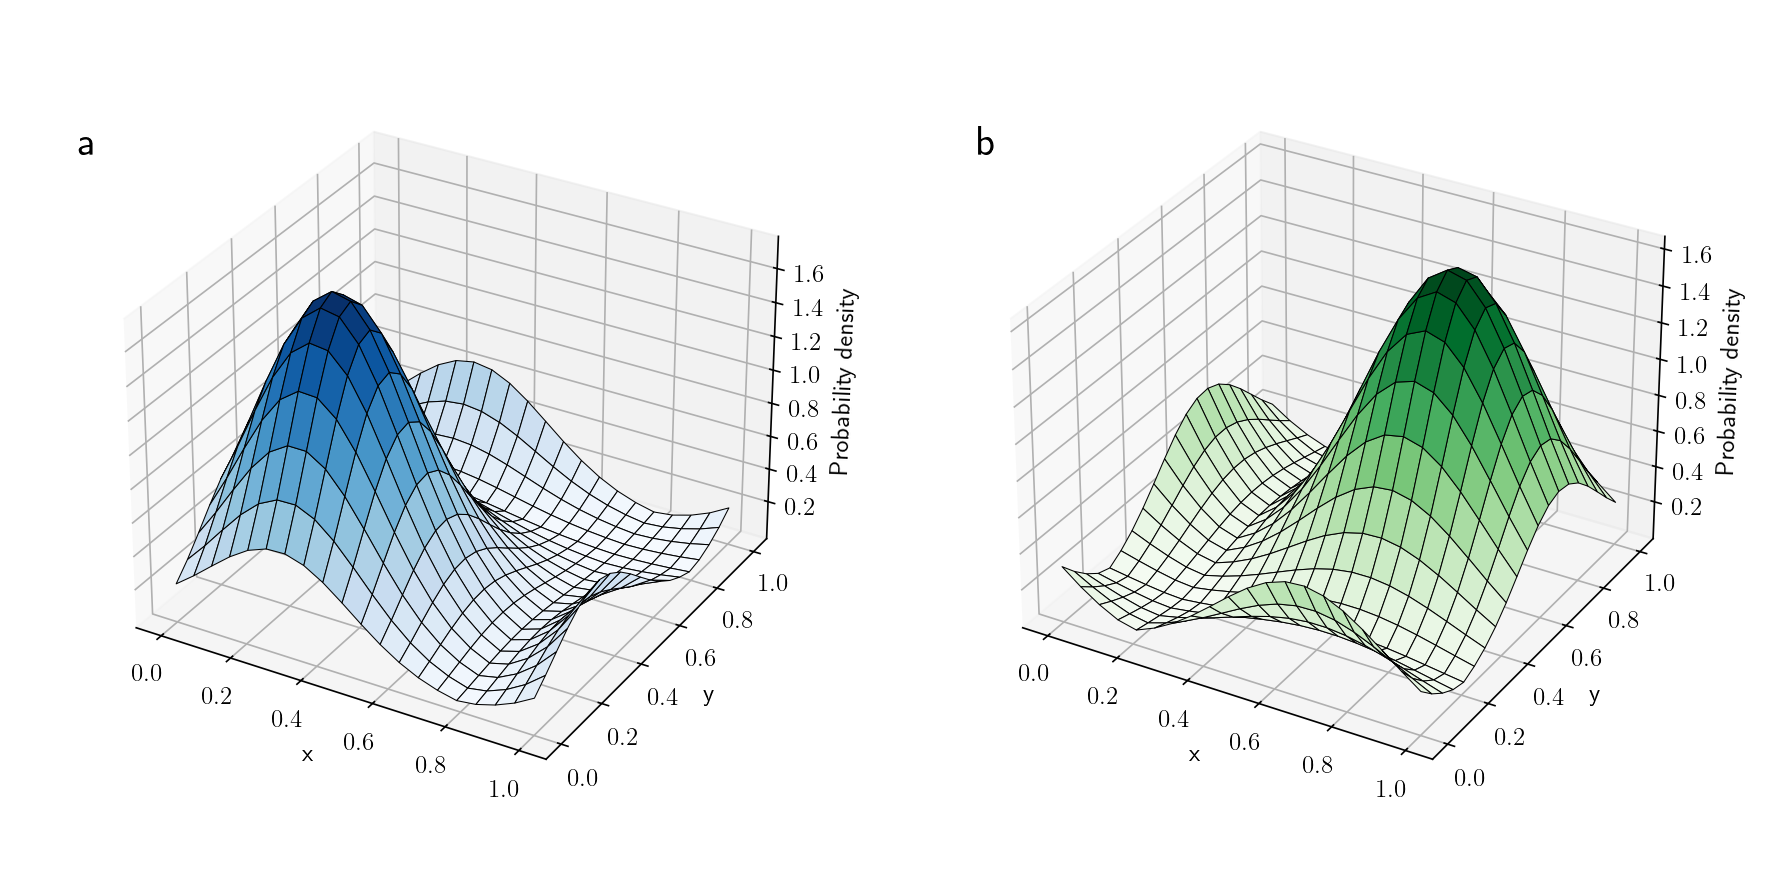

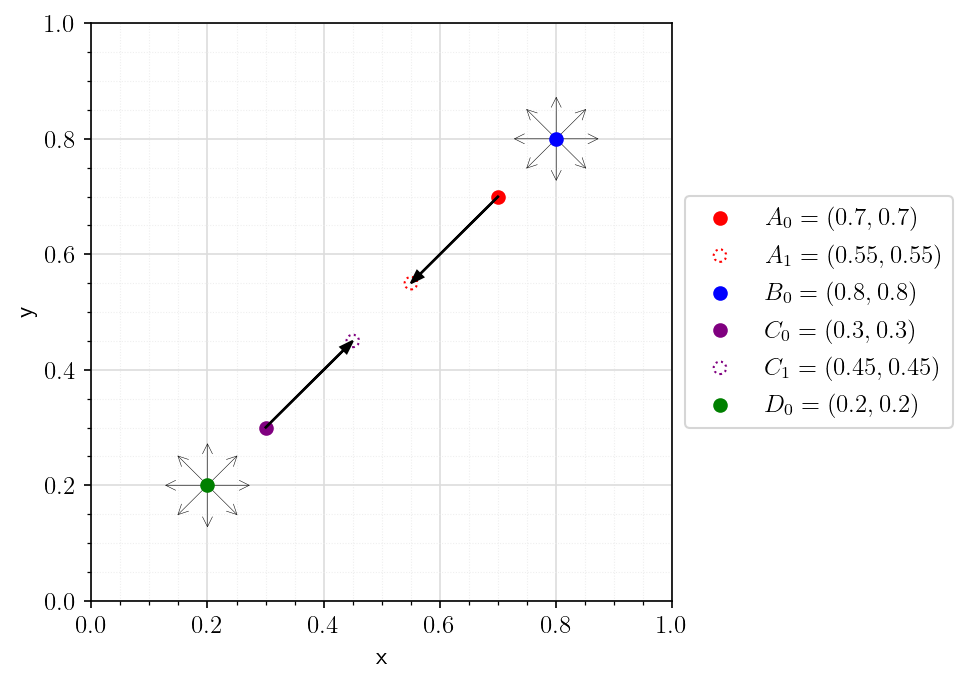

In [6]:
def calculate_transition_density_probs(A0, B0, A1, DT, N_C, user, xx, yy):
    # Load our trained model.
    model = load_mdn(DT, N_C, user)

    # Load the model scalers.
    X_scaler, Y_scaler = load_scalers(DT, N_C, user)

    # Combine the initial positions to get a vector our model can understand.
    initial_position = make_position(A0, B0).T

    # Initialise the distribution with the data to condition on.
    model_at_init = model(X_scaler.standardise(initial_position))

    disc_n = xx.shape[0]

    B1_positions = np.vstack([xx.ravel(), yy.ravel()])
    A1_positions = np.repeat(A1, disc_n**2, axis=1)

    updated_positions = np.vstack([A1_positions, B1_positions])
    probs = np.zeros_like(xx.ravel())

    for i in range(updated_positions.shape[1]):
        p = updated_positions[:, i]
        prob = given(p.T, initial_position, X_scaler, Y_scaler, model_at_init)
        probs[i] = prob.item()

    return probs

def plot_transition_densities(A0, B0, C0, D0, A1, C1, DT, N_C, user, disc_n=20):
    # Define our grid for the possible locations of B1.
    x = np.linspace(0, 1, disc_n)
    y = np.linspace(0, 1, disc_n)
    xx, yy = np.meshgrid(x, y, copy=True)
    
    A_probs = calculate_transition_density_probs(A0, B0, A1, DT, N_C, user, xx, yy).reshape(xx.shape)
    C_probs = calculate_transition_density_probs(C0, D0, C1, DT, N_C, user, xx, yy).reshape(xx.shape)
    
    fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 8))

    axs[0].plot_surface(xx, yy, A_probs, cmap="Blues", linewidth=0.5, edgecolors='k')
    axs[1].plot_surface(xx, yy, C_probs, cmap="Greens", linewidth=0.5, edgecolors='k')

    fig.text(0.05, 0.75, "a", va='center', rotation='horizontal', fontsize=20)
    fig.text(0.55, 0.75, "b", va='center', rotation='horizontal', fontsize=20)

    for ax in axs.flatten():
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("Probability density")
        ax.set_box_aspect(None, zoom=0.85)

    fig.tight_layout()

# Model parameters.
N_C = 32
DT = 4
user = "masha"

# Define the initial positions of the first pair.
A0 = np.array([0.7, 0.7]).reshape(2, 1)
B0 = np.array([0.8, 0.8]).reshape(2, 1)
# Fix the position of the second particle of the pair after the time step.
A1 = np.array([0.55, 0.55]).reshape(2, 1)

# Define the initial positions of our second pair,
C0 = np.array([0.3, 0.3]).reshape(2, 1)
D0 = np.array([0.2, 0.2]).reshape(2, 1)
# Fix the position of the first particle of the pair after the time step.
C1 = np.array([0.45, 0.45]).reshape(2, 1)

_ = plot_transition_densities(A0, B0, C0, D0, A1, C1, DT, N_C, user)
plot_positions(A0, B0, C0, D0, A1, C1)